In [7]:
# Load entire dataset using ImageFolder (folder structure-based dataset organization)
data_dir = "C:/Users/Indhuma/Downloads/ctscan-dataset/"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix     

In [8]:
# -----------------------
# CONFIGURATION VARIABLES
# -----------------------
image_size = 224  # Resize images to 224x224 pixels
num_classes = 2  # Binary classification: COVID and Non-COVID
num_epochs = 5
learning_rate = 0.0001
batch_size = 16
use_early_stopping = True
patience = 3
dropout_rate = 0.5
train_split_ratio = 0.8  # Ratio of the dataset to use for training

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device (GPU preferable for deep learning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images to [-1, 1]
])

In [10]:
# Load entire dataset using ImageFolder (folder structure-based dataset organization)
data_dir = "C:/Users/Indhuma/Downloads/ctscan-dataset/"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [11]:
# Split dataset into training and test sets
train_size = int(train_split_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Define a custom CNN model
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc1 = nn.Linear(64 * (image_size // 8) * (image_size // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [13]:
# Initialize pre-trained models and custom CNN
def initialize_models(num_classes):
    models_dict = {}

    # Custom CNN
    models_dict['Custom_CNN'] = CNN(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    # VGG16
    vgg16 = models.vgg16(pretrained=True)
    vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
    models_dict['VGG16'] = vgg16.to(device)

    # VGG19
    vgg19 = models.vgg19(pretrained=True)
    vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, num_classes)
    models_dict['VGG19'] = vgg19.to(device)

    # ResNet50
    resnet50 = models.resnet50(pretrained=True)
    resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
    models_dict['ResNet50'] = resnet50.to(device)

    return models_dict


In [14]:
# Train and evaluate all models
def train_and_evaluate(models_dict):
    criterion = nn.CrossEntropyLoss()
    results = {}

    for model_name, model in models_dict.items():
        print(f"\nTraining {model_name}...")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        best_val_loss = float('inf')
        epochs_no_improve = 0
        loss_history = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            loss_history.append(train_loss)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

            # Early stopping
            if use_early_stopping:
                if train_loss < best_val_loss:
                    best_val_loss = train_loss
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), f"best_{model_name}.pth")
                else:
                    epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping triggered for {model_name}.")
                    break

        # Load the best model
        model.load_state_dict(torch.load(f"best_{model_name}.pth"))

        # Evaluate the model on the test set
        model.eval()
        all_labels = []
        all_preds = []
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        # Calculate accuracy
        accuracy = 100 * correct / total
        print(f"Accuracy of {model_name} on test images: {accuracy:.2f}%")

        # Save results
        results[model_name] = {
            "accuracy": accuracy,
            "classification_report": classification_report(all_labels, all_preds, target_names=dataset.classes, output_dict=True),
            "confusion_matrix": confusion_matrix(all_labels, all_preds)
        }

    return results


In [15]:
# Initialize models
models_dict = initialize_models(num_classes=num_classes)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights

In [16]:
# Train and evaluate models
results = train_and_evaluate(models_dict)


Training Custom_CNN...
Epoch [1/5], Loss: 0.6002
Epoch [2/5], Loss: 0.4529
Epoch [3/5], Loss: 0.3436
Epoch [4/5], Loss: 0.2999
Epoch [5/5], Loss: 0.2512


C:\Users\Indhuma\AppData\Local\Temp\ipykernel_9040\1820454954.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_{model_name}.pth")

Accuracy of Custom_CNN on test images: 90.14%

Training VGG16...
Epoch [1/5], Loss: 0.3364
Epoch [2/5], Loss: 0.1838
Epoch [3/5], Loss: 0.1216
Epoch [4/5], Loss: 0.0319
Epoch [5/5], Loss: 0.0760


C:\Users\Indhuma\AppData\Local\Temp\ipykernel_9040\1820454954.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_{model_name}.pth")

Accuracy of VGG16 on test images: 98.19%

Training VGG19...
Epoch [1/5], Loss: 0.3826
Epoch [2/5], Loss: 0.1852
Epoch [3/5], Loss: 0.1424
Epoch [4/5], Loss: 0.1746
Epoch [5/5], Loss: 0.0516


C:\Users\Indhuma\AppData\Local\Temp\ipykernel_9040\1820454954.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_{model_name}.pth")

Accuracy of VGG19 on test images: 94.37%

Training ResNet50...
Epoch [1/5], Loss: 0.2214
Epoch [2/5], Loss: 0.1197
Epoch [3/5], Loss: 0.0520
Epoch [4/5], Loss: 0.0254
Epoch [5/5], Loss: 0.0162


C:\Users\Indhuma\AppData\Local\Temp\ipykernel_9040\1820454954.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_{model_name}.pth")

Accuracy of ResNet50 on test images: 99.40%



Classification Report for Custom_CNN:
{'COVID': {'precision': 0.8961038961038961, 'recall': 0.8922413793103449, 'f1-score': 0.8941684665226782, 'support': 232.0}, 'non-COVID': {'precision': 0.9060150375939849, 'recall': 0.909433962264151, 'f1-score': 0.9077212806026366, 'support': 265.0}, 'accuracy': 0.9014084507042254, 'macro avg': {'precision': 0.9010594668489404, 'recall': 0.9008376707872479, 'f1-score': 0.9009448735626574, 'support': 497.0}, 'weighted avg': {'precision': 0.9013885087696377, 'recall': 0.9014084507042254, 'f1-score': 0.9013948160824146, 'support': 497.0}}

Confusion Matrix for Custom_CNN:
[[207  25]
 [ 24 241]]


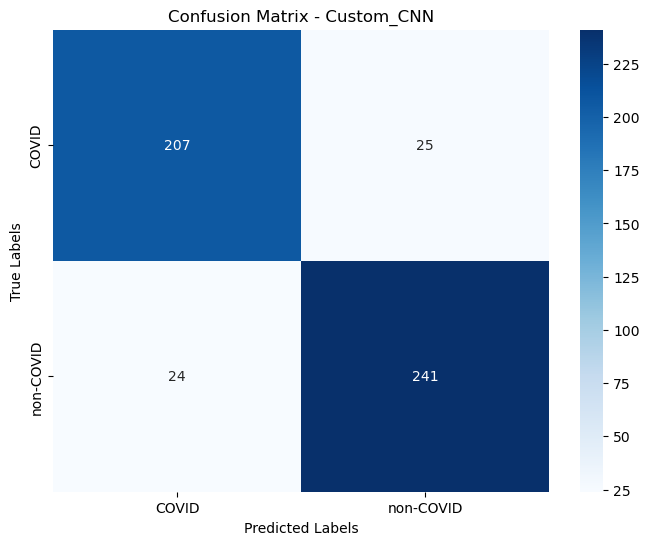


Classification Report for VGG16:
{'COVID': {'precision': 0.9665271966527197, 'recall': 0.9956896551724138, 'f1-score': 0.9808917197452229, 'support': 232.0}, 'non-COVID': {'precision': 0.9961240310077519, 'recall': 0.969811320754717, 'f1-score': 0.982791586998088, 'support': 265.0}, 'accuracy': 0.9818913480885312, 'macro avg': {'precision': 0.9813256138302358, 'recall': 0.9827504879635653, 'f1-score': 0.9818416533716554, 'support': 497.0}, 'weighted avg': {'precision': 0.982308204910433, 'recall': 0.9818913480885312, 'f1-score': 0.9819047274353823, 'support': 497.0}}

Confusion Matrix for VGG16:
[[231   1]
 [  8 257]]


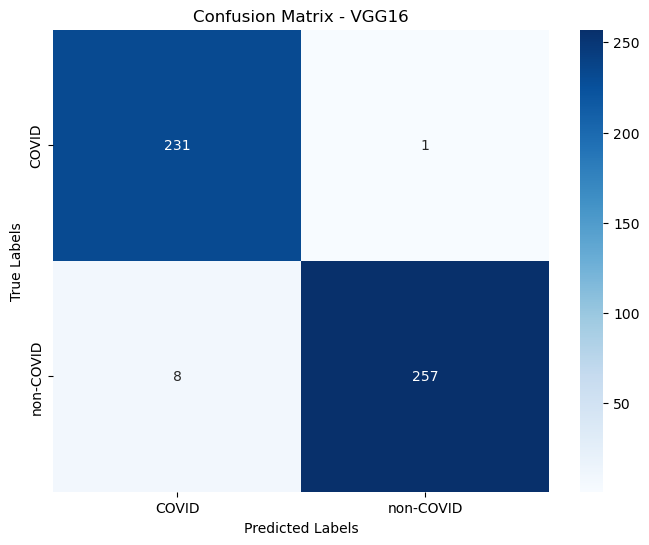


Classification Report for VGG19:
{'COVID': {'precision': 0.9951456310679612, 'recall': 0.8836206896551724, 'f1-score': 0.9360730593607306, 'support': 232.0}, 'non-COVID': {'precision': 0.9072164948453608, 'recall': 0.9962264150943396, 'f1-score': 0.9496402877697842, 'support': 265.0}, 'accuracy': 0.9436619718309859, 'macro avg': {'precision': 0.951181062956661, 'recall': 0.939923552374756, 'f1-score': 0.9428566735652574, 'support': 497.0}, 'weighted avg': {'precision': 0.948261886401987, 'recall': 0.9436619718309859, 'f1-score': 0.9433070946291394, 'support': 497.0}}

Confusion Matrix for VGG19:
[[205  27]
 [  1 264]]


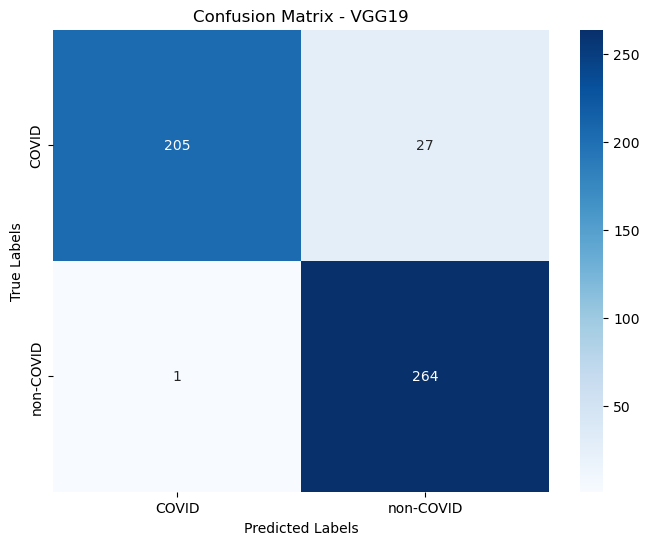


Classification Report for ResNet50:
{'COVID': {'precision': 0.9872340425531915, 'recall': 1.0, 'f1-score': 0.9935760171306209, 'support': 232.0}, 'non-COVID': {'precision': 1.0, 'recall': 0.9886792452830189, 'f1-score': 0.9943074003795066, 'support': 265.0}, 'accuracy': 0.993963782696177, 'macro avg': {'precision': 0.9936170212765958, 'recall': 0.9943396226415094, 'f1-score': 0.9939417087550637, 'support': 497.0}, 'weighted avg': {'precision': 0.9940408407894173, 'recall': 0.993963782696177, 'f1-score': 0.9939659900902884, 'support': 497.0}}

Confusion Matrix for ResNet50:
[[232   0]
 [  3 262]]


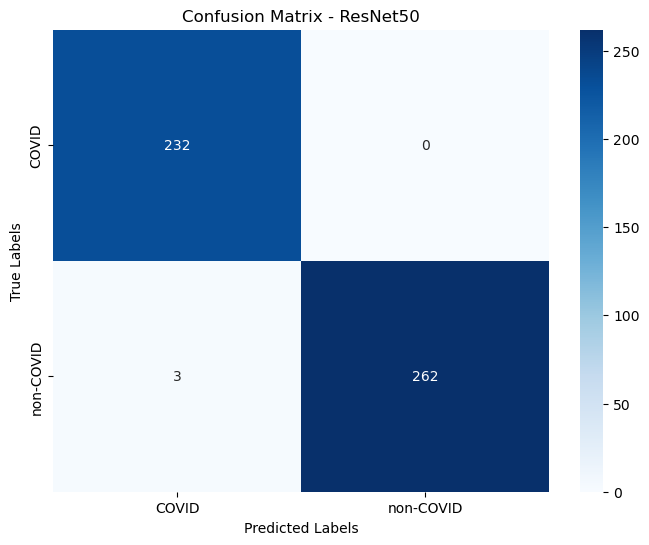

In [17]:
# Visualize confusion matrices
for model_name, result in results.items():
    print(f"\nClassification Report for {model_name}:")
    print(result["classification_report"])

    print(f"\nConfusion Matrix for {model_name}:")
    print(result["confusion_matrix"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()